In [1]:
import os, sys

recsys_cf = os.environ.get("RECSYS_STORY")
sys.path.append(recsys_cf)
os.chdir(recsys_cf)

from lib.tools import *

In [2]:
# Preproc
from sklearn.preprocessing import MinMaxScaler

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score,  f1_score

# Model
from pyspark.ml.recommendation import ALS, ALSModel

In [3]:
%matplotlib inline

###### spark 

In [4]:
sp = spark(**SPARK_CONFIG)
hive = sp.sql

###### load data 

In [5]:
train_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_TRAIN_POS, hive)

In [6]:
val_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_DATASET_VAL, hive)

In [7]:
test_sdf = load_table(SBX_TEAM_DIGITCAMP, RECSYS_STORY_TEST, hive)

In [8]:
test_sdf.filter("rating = 1").count()

2482

In [9]:
%%time
train = train_sdf.toPandas()
val = val_sdf.toPandas()
test = test_sdf.toPandas()

CPU times: user 47.4 s, sys: 4.12 s, total: 51.6 s
Wall time: 55.2 s


In [10]:
COL_USER = "user_id"
COL_ITEM = "item_id"
COL_TIMESTAMP = "timestamp"
COL_RATING = "rating"
COL_PREDICTION = "prediction"

###### model 

In [11]:
params = {
    'alpha': 5,
    'maxIter': 5,
    'nonnegative': False,
    'rank': 40,
    'regParam': 1.0
}

После подбора гиперпараметров

In [11]:
params = {'maxIter': 6, 'alpha': 1, 'nonnegative': False, 'rank': 10, 'regParam': 1.0}

In [12]:
header = {
    "userCol": COL_USER,
    "itemCol": COL_ITEM,
    "ratingCol": COL_RATING,
}

In [14]:
"popa"

'popa'

In [15]:
als = ALS(
    **header,
    **params,
    implicitPrefs=True
)

In [16]:
%%time
model = als.fit(train_sdf)

CPU times: user 17.1 ms, sys: 13.4 ms, total: 30.5 ms
Wall time: 19.2 s


###### Предсказания 

In [17]:
%%time
pred_sdf = model.transform(test_sdf)

CPU times: user 6.63 ms, sys: 3.96 ms, total: 10.6 ms
Wall time: 56.8 ms


In [18]:
pred = pred_sdf.toPandas()

###### Масштабирование рейтинга 

In [19]:
pred["prediction_raw"] = pred["prediction"]
pred["prediction"] = MinMaxScaler().fit_transform(pred[["prediction"]])

In [20]:
pred.head()

,user_id,item_id,timestamp,rating,prediction,prediction_raw
0,396625,214250791,NaN,0.0,0.064478,0.000691
1,496307,214250791,NaN,0.0,0.032099,0.000092
2,871377,214250791,NaN,0.0,0.028010,0.000017
3,816669,214250791,NaN,0.0,0.057573,0.000563
4,826977,214250791,NaN,0.0,0.067341,0.000744


###### Метрики классификации 

Гистограмма рейтингов

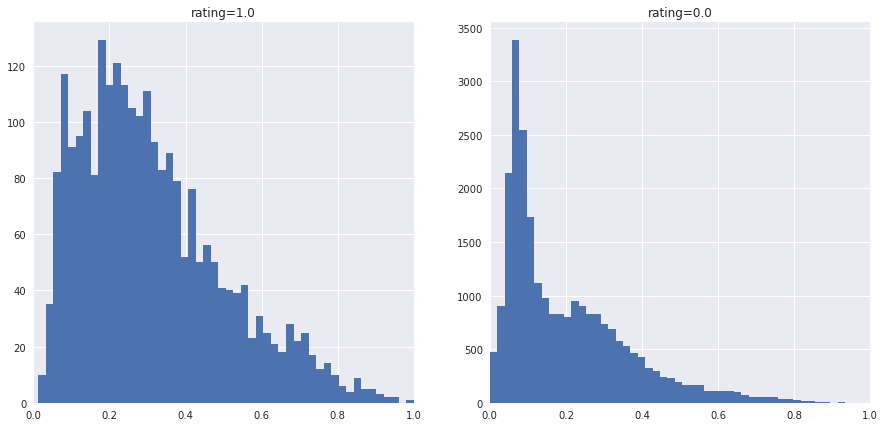

In [21]:
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1), plt.xlim((0, 1))
plt.hist(pred[pred.rating == 1.0].prediction, bins=50), 
plt.title("rating=1.0")

plt.subplot(1, 2, 2), plt.xlim((0, 1))
plt.hist(pred[pred.rating == 0.0].prediction, bins=50), 
plt.title("rating=0.0")
None

Вероятностные метрики 

In [22]:
pred_col = [pred.rating, pred.prediction]

roc_auc = roc_auc_score(*pred_col)
log_loss_score = log_loss(*pred_col)

print("ROC_AUC: {:.4f}".format(roc_auc))
print("Log loss: {:.4f}".format(log_loss_score))

ROC_AUC: 0.6946
Log loss: 0.3499


###### Выбор порогового значения 

ROC thresholds-moving

In [23]:
fpr, tpr, thresholds_roc = roc_curve(*pred_col)

sensitivity = tpr
specificity = 1 - fpr
gmeans = np.sqrt(sensitivity * specificity)

ix_gmean = np.argmax(gmeans)
best_thresholds_roc = thresholds_roc[ix_gmean]
best_gmean = gmeans[ix_gmean]

print("Best thresholds: {:.4f} for G-mean: {:.4f}".format(best_thresholds_roc, best_gmean))

Best thresholds: 0.1661 for G-mean: 0.6407


PR curve thresholds-moving

In [24]:
precision, recall, thresholds_pr = precision_recall_curve(*pred_col)

fscore = (2 * precision * recall) / (precision + recall)
fscore[np.isnan(fscore)] = 0

ix_fscore = np.argmax(fscore)
best_thresholds_pr = thresholds_pr[ix_fscore]
best_fscore = fscore[ix_fscore]

print("Best thresholds: {:.4f} for F-score: {:.4f}".format(best_thresholds_pr, best_fscore))

Best thresholds: 0.2859 for F-score: 0.2389


Plots

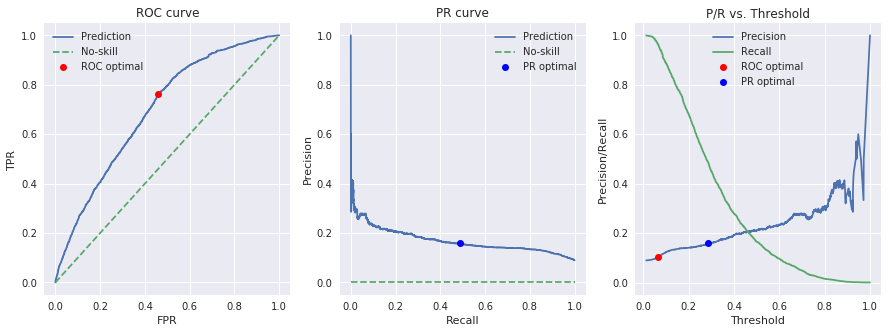

In [25]:
plt.figure(figsize=(15, 5))

#############################################################

plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, "-", label="Prediction")
plt.plot([0, 1], [0, 1], "--", label="No-skill")
plt.plot(fpr[ix_gmean], tpr[ix_gmean], "or", label="ROC optimal")

plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

#############################################################

plt.subplot(1, 3, 2)
plt.plot(recall, precision, "-", label="Prediction")
plt.plot([0, 1], [0, 0], "--", label="No-skill")
plt.plot(recall[ix_fscore], precision[ix_fscore], "ob", label="PR optimal")

plt.title("PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()

#############################################################

plt.subplot(1, 3, 3)
plt.plot(thresholds_pr, precision[:-1], label="Precision")
plt.plot(thresholds_pr, recall[:-1], label="Recall")
plt.plot(thresholds_pr[ix_gmean], precision[ix_gmean], "or", label="ROC optimal")
plt.plot(thresholds_pr[ix_fscore], precision[ix_fscore], "ob", label="PR optimal")

plt.title("P/R vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Precision/Recall")
plt.legend()

plt.show()

Сlassification report

In [26]:
print("Report for best ROC threshold: {:.4f}\n".format(best_thresholds_roc))
print(classification_report(pred.rating, pred.prediction > best_thresholds_roc))

print("-"*60)

print("Report for best PR threshold: {:.4f}\n".format(best_thresholds_pr))
print(classification_report(pred.rating, pred.prediction > best_thresholds_pr))

Report for best ROC threshold: 0.1661

              precision    recall  f1-score   support

         0.0       0.96      0.54      0.69     25442
         1.0       0.14      0.76      0.23      2482

   micro avg       0.56      0.56      0.56     27924
   macro avg       0.55      0.65      0.46     27924
weighted avg       0.89      0.56      0.65     27924

------------------------------------------------------------
Report for best PR threshold: 0.2859

              precision    recall  f1-score   support

         0.0       0.94      0.75      0.83     25442
         1.0       0.16      0.49      0.24      2482

   micro avg       0.72      0.72      0.72     27924
   macro avg       0.55      0.62      0.54     27924
weighted avg       0.87      0.72      0.78     27924



###### Метрики классификации

In [27]:
pred_crisp_list = [pred.rating, pred.prediction > best_thresholds_roc]

In [28]:
tn, fp, fn, tp = confusion_matrix(*pred_crisp_list).ravel()
print("TP: {}, FP: {}".format(tp, fp))
print("FN: {}, TN: {}".format(fn, tn))

TP: 1888, FP: 11720
FN: 594, TN: 13722


In [29]:
precision_s = precision_score(*pred_crisp_list)
recall_s = recall_score(*pred_crisp_list)
f1_s = f1_score(*pred_crisp_list)

print("Precision: {:.4f}".format(precision_s))
print("Recall: {:.4f}".format(recall_s))
print("F1-score: {:.4f}".format(f1_s))

Precision: 0.1387
Recall: 0.7607
F1-score: 0.2347


###### Все метрики 

In [30]:
print("ROC_AUC: {:.4f}".format(roc_auc))

print("Precision: {:.4f}".format(precision_s))
print("Recall: {:.4f}".format(recall_s))
print("F1-score: {:.4f}".format(f1_s))


print("TP: {}, FP: {}".format(tp, fp))
print("FN: {}, TN: {}".format(fn, tn))

print("Log loss: {:.4f}".format(log_loss_score))

ROC_AUC: 0.6946
Precision: 0.1387
Recall: 0.7607
F1-score: 0.2347
TP: 1888, FP: 11720
FN: 594, TN: 13722
Log loss: 0.3499
